In [1]:
import os
import imageio
import matplotlib.pyplot as plt
import cv2

%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import (
    remove_component,
    remove_holes,
)
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal

2022-08-12 15:28:58,401-[INFO]- numexpr.utils:145 -> Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-12 15:28:58,402-[INFO]- numexpr.utils:157 -> NumExpr defaulting to 8 threads.


/home/ipausers/bisot/pycode/MscThesis/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
images_path = r"/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames"
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path, file) for file in files]
images_total_path.sort()

In [5]:
selection_file = images_total_path[3800:4100]

In [61]:
selection_file

['/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3800.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3801.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3802.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3803.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3804.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3805.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625__20220630_150115688_3806.tiff',
 '/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames/Basler_acA4112-30um__40044625_

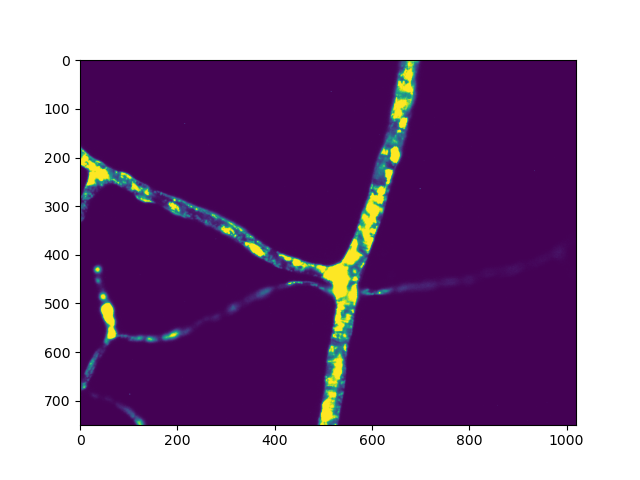

In [7]:
image = imageio.imread(selection_file[0])
fig, ax = plt.subplots()
ax.imshow(image)

In [37]:
def segment(images_adress):
    images = [imageio.imread(file) for file in images_adress]
    images = [cv2.resize(image, np.flip(images[0].shape)) for image in images]
    average_proj = np.mean(np.array(images), axis=0)
    segmented = average_proj > 10
    segmented = remove_holes(segmented)
    segmented = segmented.astype(np.uint8)
    connected = remove_component(segmented)
    connected = connected.astype(np.uint8)
    skeletonized = cv2.ximgproc.thinning(np.array(connected, dtype=np.uint8))
    skeleton = scipy.sparse.dok_matrix(skeletonized)
    nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
    nx_graph, pos = remove_spurs(nx_graph, pos, threshold=20)
    # nx_graph = clean_degree_4(nx_graph, pos)[0]
    return (skeletonized, nx_graph, pos)

In [38]:
skeletonized, nx_graph_pruned, pos = segment(selection_file[:300])

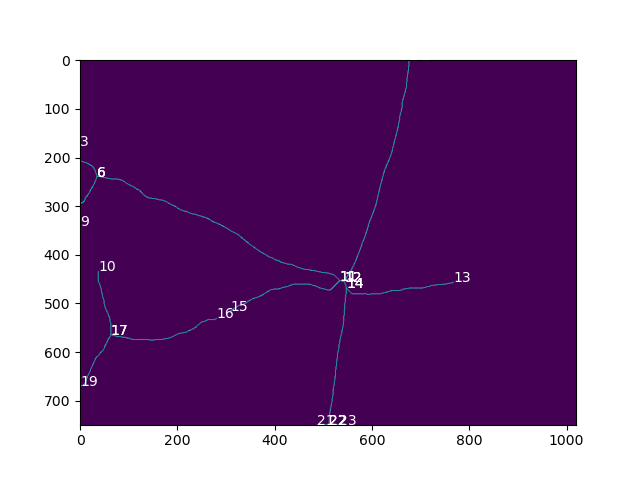

In [39]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip(pos[edge[0]]), str(edge[0]), color="white")
    ax.text(*np.flip(pos[edge[1]]), str(edge[1]), color="white")

In [57]:
edges = [
    (109, 56),
    (50, 33),
    (83, 48),
    (74, 59),
    (241, 219),
    (185, 151),
    (48, 35),
    (48, 16),
    (59, 1),
    (219, 171),
    (171, 133),
    (50, 25),
]

In [8]:
# edges = [(109,56),(50,33),(83,48),(74,59),(241,219),(185,151),(48,35),(48,16),(59,1)]

In [40]:
edges = [(12, 1), (11, 6), (22, 14)]

In [42]:
slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=5,
    target_length=10,
)

Text(0.5, 1.0, 'Slices taken along one hypha')

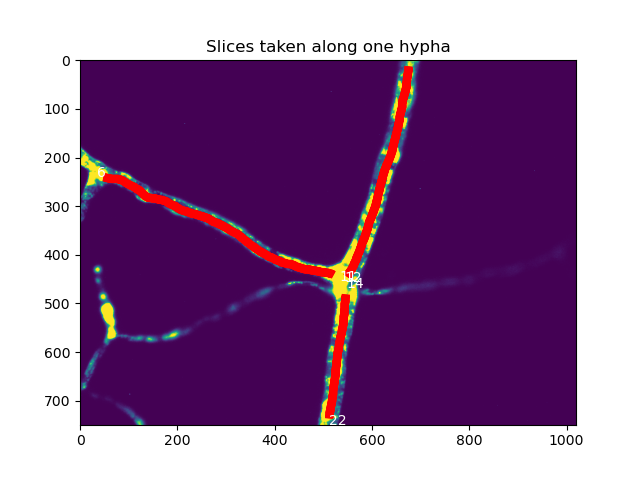

In [43]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(image)
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
        edge,
        pos,
        image,
        nx_graph_pruned,
        resolution=1,
        offset=4,
        step=15,
        target_length=10,
    )
    plot_segments_on_image(segments, ax)
    ax.text(*np.flip(pos[edge[0]]), str(edge[0]), color="white")
    ax.text(*np.flip(pos[edge[1]]), str(edge[1]), color="white")
plt.title("Slices taken along one hypha")

In [47]:
kymos = {edge: get_kymo(edge, pos, selection_file, nx_graph_pruned) for edge in edges}

In [48]:
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}

In [69]:
W = 50  # window size is WxW
time_pixel_size = 0.10  # s.pixel
space_pixel_size = 1.725 / 25  # um.pixel
speeds = {}
for edge in edges:
    imgCoherency, imgOrientation = calcGST(kymos[edge], W)
    # imgCoherency, imgOrientation = calcGST(filtered_kymos[edge][1], W)

    speeds[edge] = (
        np.tan((imgOrientation - 90) / 180 * np.pi) * space_pixel_size / time_pixel_size
    )  # um.s-1
    # speeds[edge]=speeds[edge][:,:300]

In [50]:
corrs = {}
for edge in edges:
    to_treat = (speeds[edge] - np.mean(speeds[edge])) / np.std(speeds[edge])
    corr = signal.correlate2d(to_treat, to_treat)
    corrs[edge] = corr / np.max(corr)

In [51]:
import math


def gridplot(
    n: int,
    ncols=None,
    subw: float = 4.0,
    subh: float = 4.0,
    **kwargs,
):
    if ncols is None:
        ncols = n
    nrows = math.ceil(n / ncols)
    figsize = (subw * ncols, subh * nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    return fig, iter(axs.flatten())

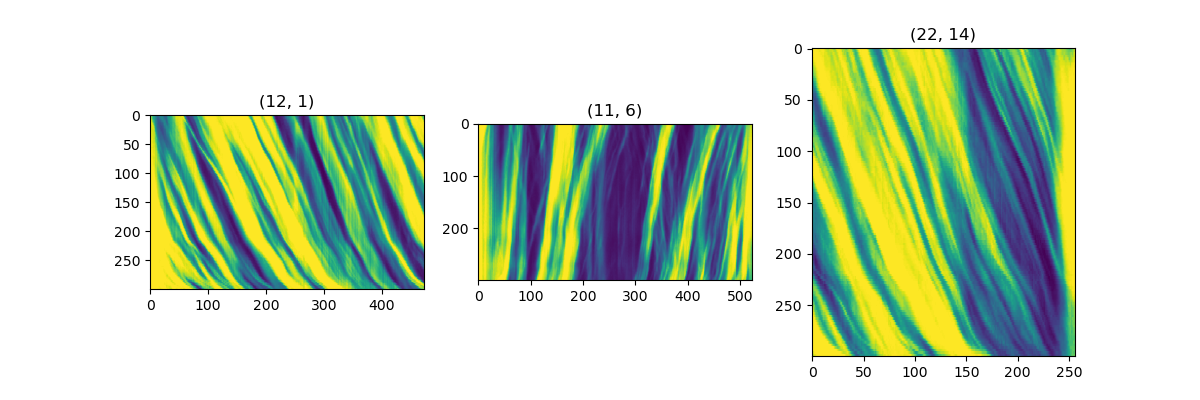

In [52]:
fig, axs = gridplot(len(kymos), ncols=3)
for i, ax in enumerate(axs):
    ax.imshow(kymos[edges[i]])
    ax.set_title(str(edges[i]))

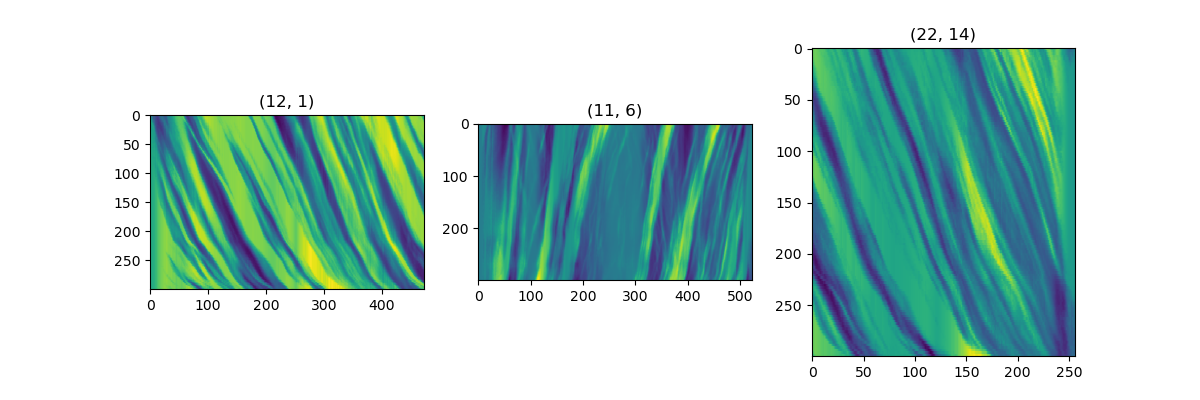

In [57]:
fig, axs = gridplot(len(kymos), ncols=3)
for i, ax in enumerate(axs):
    ax.imshow(filtered_kymos[edges[i]][1])
    ax.set_title(str(edges[i]))

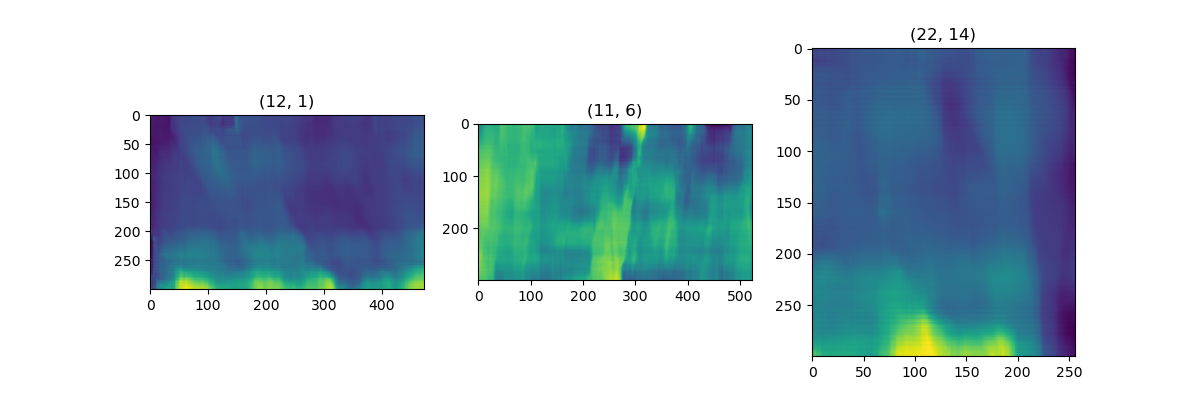

In [67]:
fig, axs = gridplot(len(kymos), ncols=3)
for i, ax in enumerate(axs):
    ax.imshow(speeds[edges[i]])
    ax.set_title(str(edges[i]))

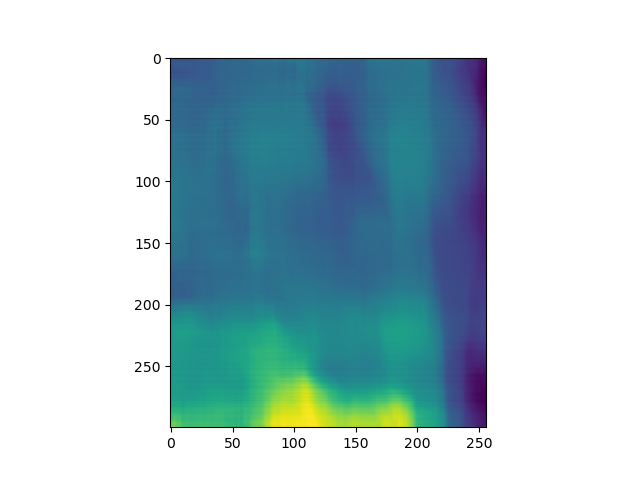

In [65]:
imgCoherency, imgOrientation = calcGST(kymos[edge], 50)
fix, ax = plt.subplots()
ax.imshow(imgOrientation)

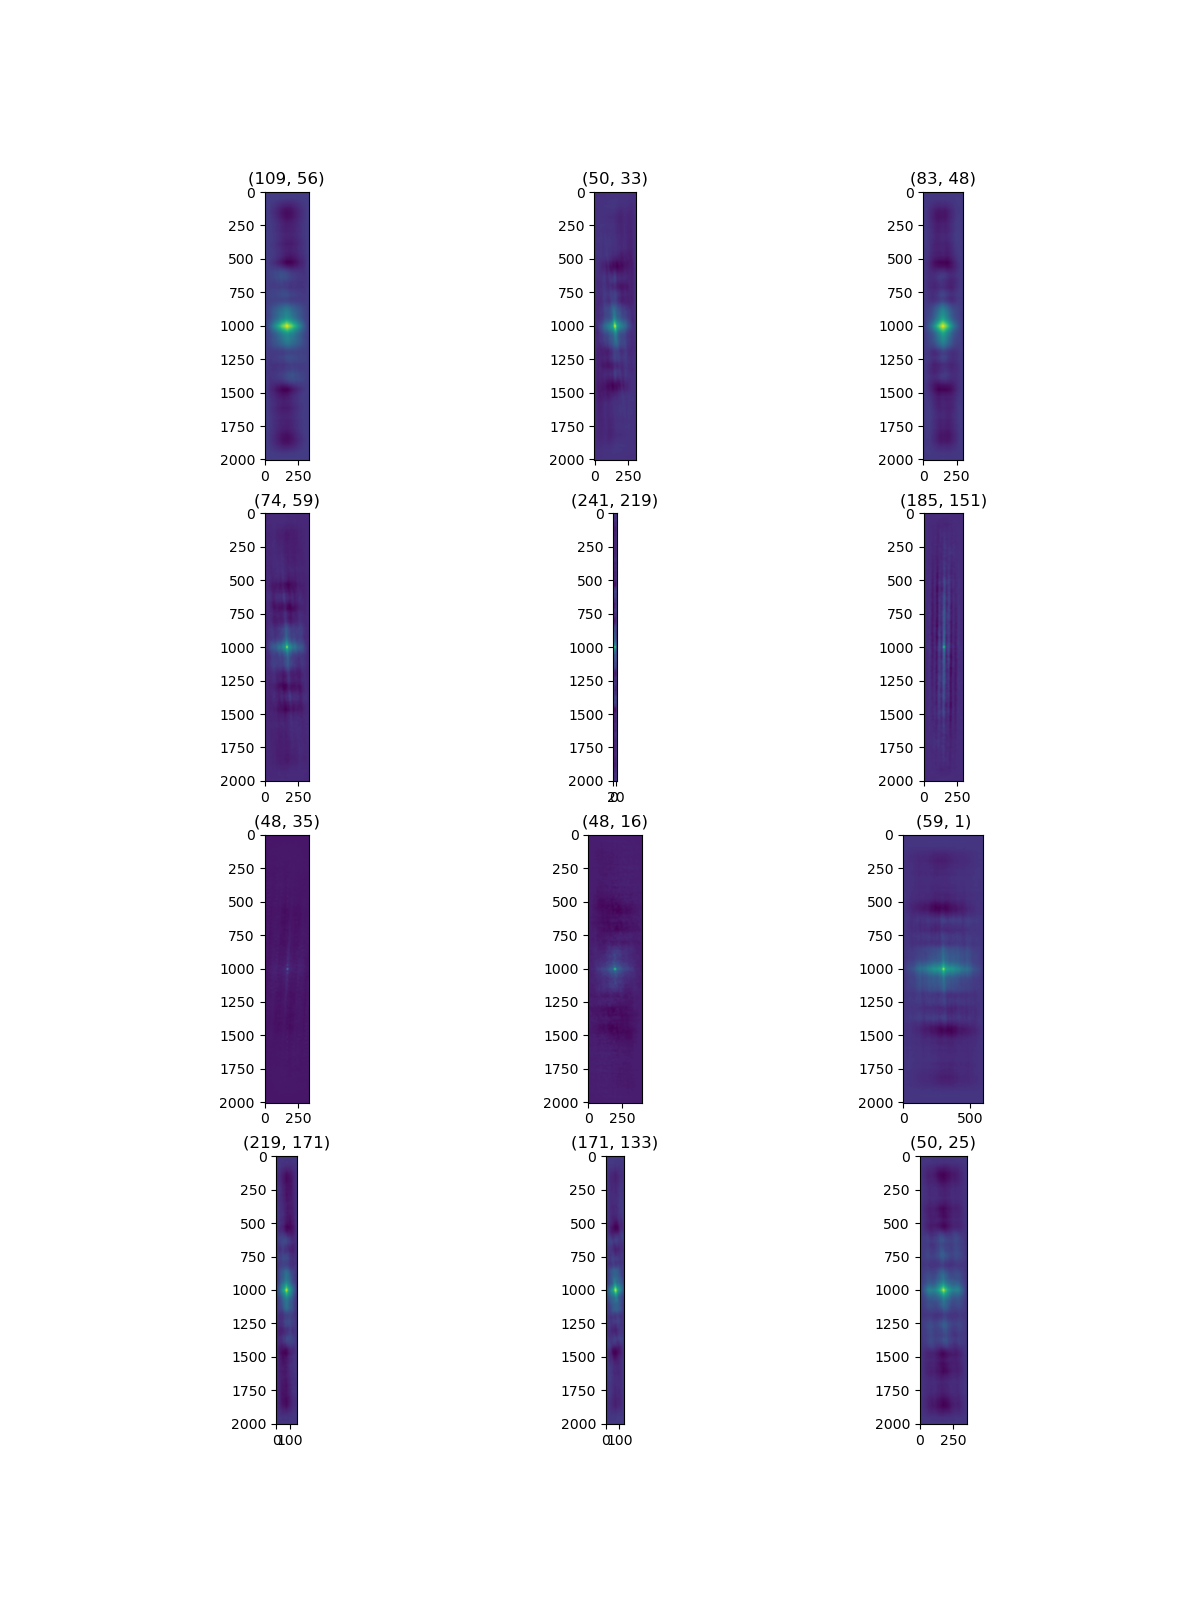

In [19]:
fig, axs = gridplot(len(kymos), ncols=3)
for i, ax in enumerate(axs):
    ax.imshow(corrs[edges[i]])
    ax.set_title(str(edges[i]))

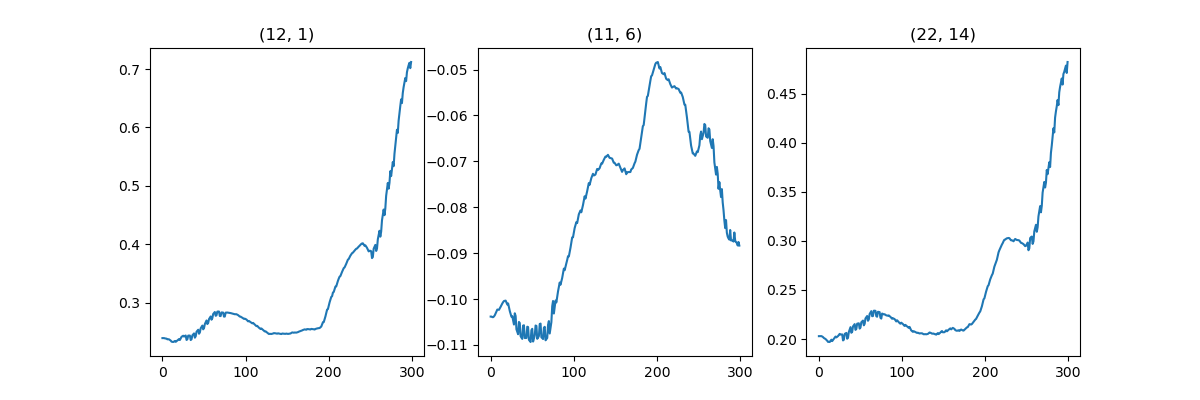

In [70]:
mean_speed = {edge: np.mean(speeds[edge], axis=1) for edge in edges}
fig, axs = gridplot(len(kymos), ncols=3)
for i, ax in enumerate(axs):
    ax.plot(mean_speed[edges[i]])
    ax.set_title(str(edges[i]))
    # ax.set_ylim((0,-8.5))

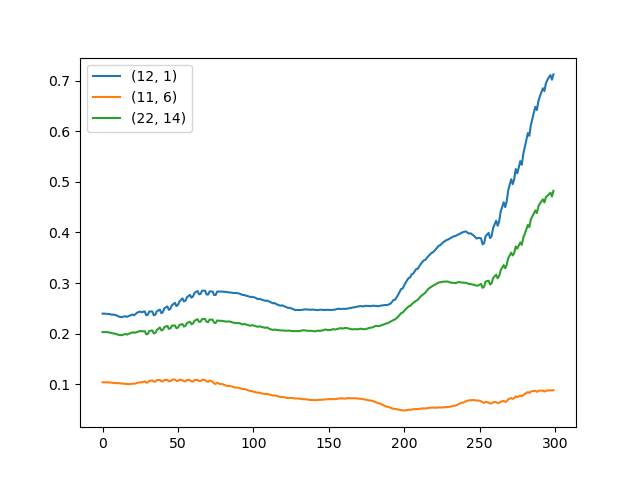

In [72]:
fig, ax = plt.subplots()
for edge in edges:
    ax.plot(np.abs(mean_speed[edge]), label=edge)
# ax.set_ylim(0,-10)
plt.legend()

In [50]:
cross_corrs = {}
signal_compare = (mean_speed[(219, 171)] - np.mean(mean_speed[(219, 171)])) / (
    np.std(mean_speed[(219, 171)])
)
for edge in edges:
    signal_2 = (mean_speed[edge] - np.mean(mean_speed[edge])) / (
        np.std(mean_speed[edge])
    )

    cross_corrs[edge] = signal.correlate(signal_2, signal_compare)

In [48]:
cross_corrs[edge]

array([3313.1567], dtype=float32)

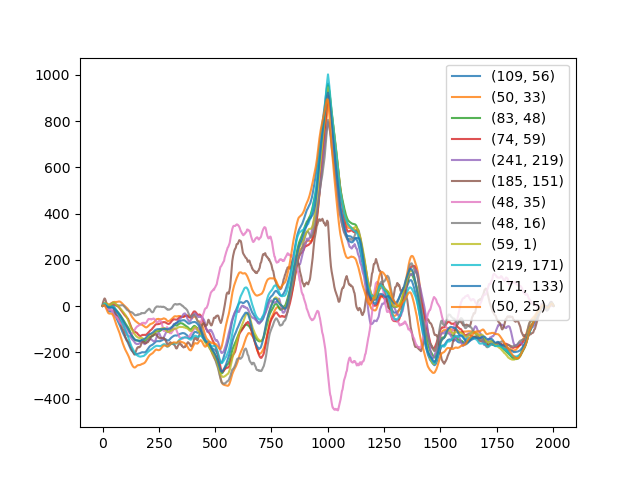

In [58]:
fig, ax = plt.subplots()
for edge in edges:
    time_corr = cross_corrs[edge]
    ts = np.linspace(0, length_time / 2, len(time_corr))
    length_time = time_pixel_size * len(time_corr)
    ax.plot(time_corr, label=edge, alpha=0.8)


plt.legend()

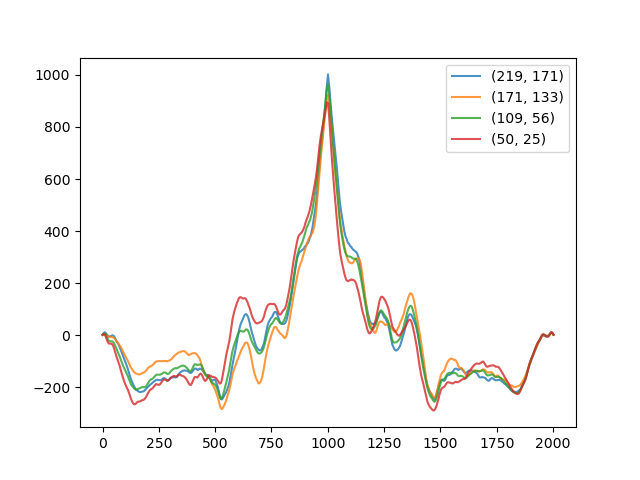

In [67]:
fig, ax = plt.subplots()
for edge in [(219, 171), (171, 133), (109, 56), (50, 25)]:
    time_corr = cross_corrs[edge]
    ts = np.linspace(0, length_time / 2, len(time_corr))
    length_time = time_pixel_size * len(time_corr)
    ax.plot(time_corr, label=edge, alpha=0.8)


plt.legend()

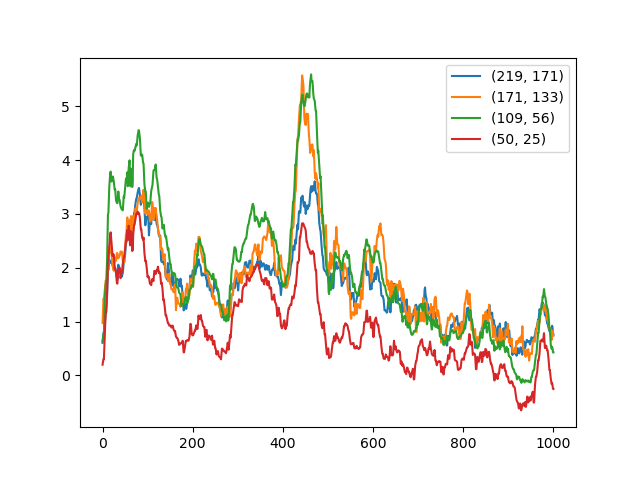

In [66]:
fig, ax = plt.subplots()
for edge in [(219, 171), (171, 133), (109, 56), (50, 25)]:
    ax.plot(mean_speed[edge], label=edge)

plt.legend()